In [1]:
from torch import cuda, bfloat16
import transformers

model_name = '/home/ubuntu/model/falcon-40b-instruct'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto'
)
model.eval()
print(f"Model loaded on {device}")

/home/ubuntu/dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ubuntu/dev/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
ERROR: /home/ubuntu/dev/bin/python: undefined symbol: cudaRuntimeGetVersion
CUDA SETUP: libcudart.so path is None
CUDA SETUP: Is seems that your cuda installation is not in your path. See https://github.com/TimDettmers/bitsandbytes/issues/85 for more information.
CUDA SETUP: CUDA version lower than 11 are currently not supported for LLM.int8(). You will be only to use 8-bit optimizers and quantization routines!!
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 00
CUDA SETUP: Loading bi

/home/ubuntu/dev/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('https'), PosixPath('//debuginfod.ubuntu.com ')}
  warn(msg)
/home/ubuntu/dev/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/ubuntu/dev/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)
/home/ubuntu/dev/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/cuda/lib64')}
  warn(msg

Model loaded on cuda:0


In [2]:
import transformers
from transformers import StoppingCriteria, StoppingCriteriaList
import torch


tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [4]:
import transformers
from transformers import StoppingCriteria, StoppingCriteriaList
import torch


tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
# we create a list of stopping criteria
stop_token_ids = [
    tokenizer.convert_tokens_to_ids(x) for x in [
        ['Human', ':'], ['AI', ':']
    ]
]
stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]

In [6]:
from transformers import StoppingCriteria, StoppingCriteriaList

# define custom stopping criteria object
class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_ids in stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():
                return True
        return False

stopping_criteria = StoppingCriteriaList([StopOnTokens()])

In [7]:
generate_text = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    return_full_text=True,  # langchain expects the full text
    task='text-generation',
    # we pass model parameters here too
    #stopping_criteria=stopping_criteria,  # without this model rambles during chat
    temperature=0.0,  # 'randomness' of outputs, 0.0 is the min and 1.0 the max
    max_new_tokens=512,  # mex number of tokens to generate in the output
    repetition_penalty=1.1  # without this output begins repeating
)

The model 'RWForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'R

In [8]:
from langchain import PromptTemplate, LLMChain
from langchain.llms import HuggingFacePipeline
llm = HuggingFacePipeline(pipeline=generate_text)

In [9]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

hf_model = "Salesforce/blip-image-captioning-large"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = BlipProcessor.from_pretrained(hf_model)
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

In [10]:
from langchain.tools import BaseTool
from math import pi
from typing import Union


class CircumferenceTool(BaseTool):
    name = "Circumference calculator"
    description = "use this tool when you need to calculate a circumference using the radius of a circle"

    def _run(self, radius: Union[int, float]):
        return float(radius)*2.0*pi
    
    def _arun(self, radius: Union[int, float]):
        raise NotImplementedError("This tool does not support async")

In [11]:
from langchain.agents import initialize_agent
tools = [CircumferenceTool()]

# initialize agent with tools
agent = initialize_agent(
    agent="zero-shot-react-description",
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate'
)

In [12]:
agent("can you calculate the circumference of a circle that has a radius of 7.81mm")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


 yes, I can use the Circumference calculator tool
Action: Circumference calculator
Action Input: 7.81
Observation: 49.071677249072565
Thought: I now know the final answer
Final Answer: 49.071677249072565

> Finished chain.


{'input': 'can you calculate the circumference of a circle that has a radius of 7.81mm',
 'output': '49.071677249072565'}

In [14]:
print(agent.agent.llm_chain.prompt)

input_variables=['input', 'agent_scratchpad'] output_parser=None partial_variables={} template='Answer the following questions as best you can. You have access to the following tools:\n\nCircumference calculator: use this tool when you need to calculate a circumference using the radius of a circle\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [Circumference calculator]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}' template_format='f-string' validate_template=True


In [12]:

import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

hf_model = "Salesforce/blip-image-captioning-large"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

processor = BlipProcessor.from_pretrained(hf_model)
model = BlipForConditionalGeneration.from_pretrained(hf_model).to(device)

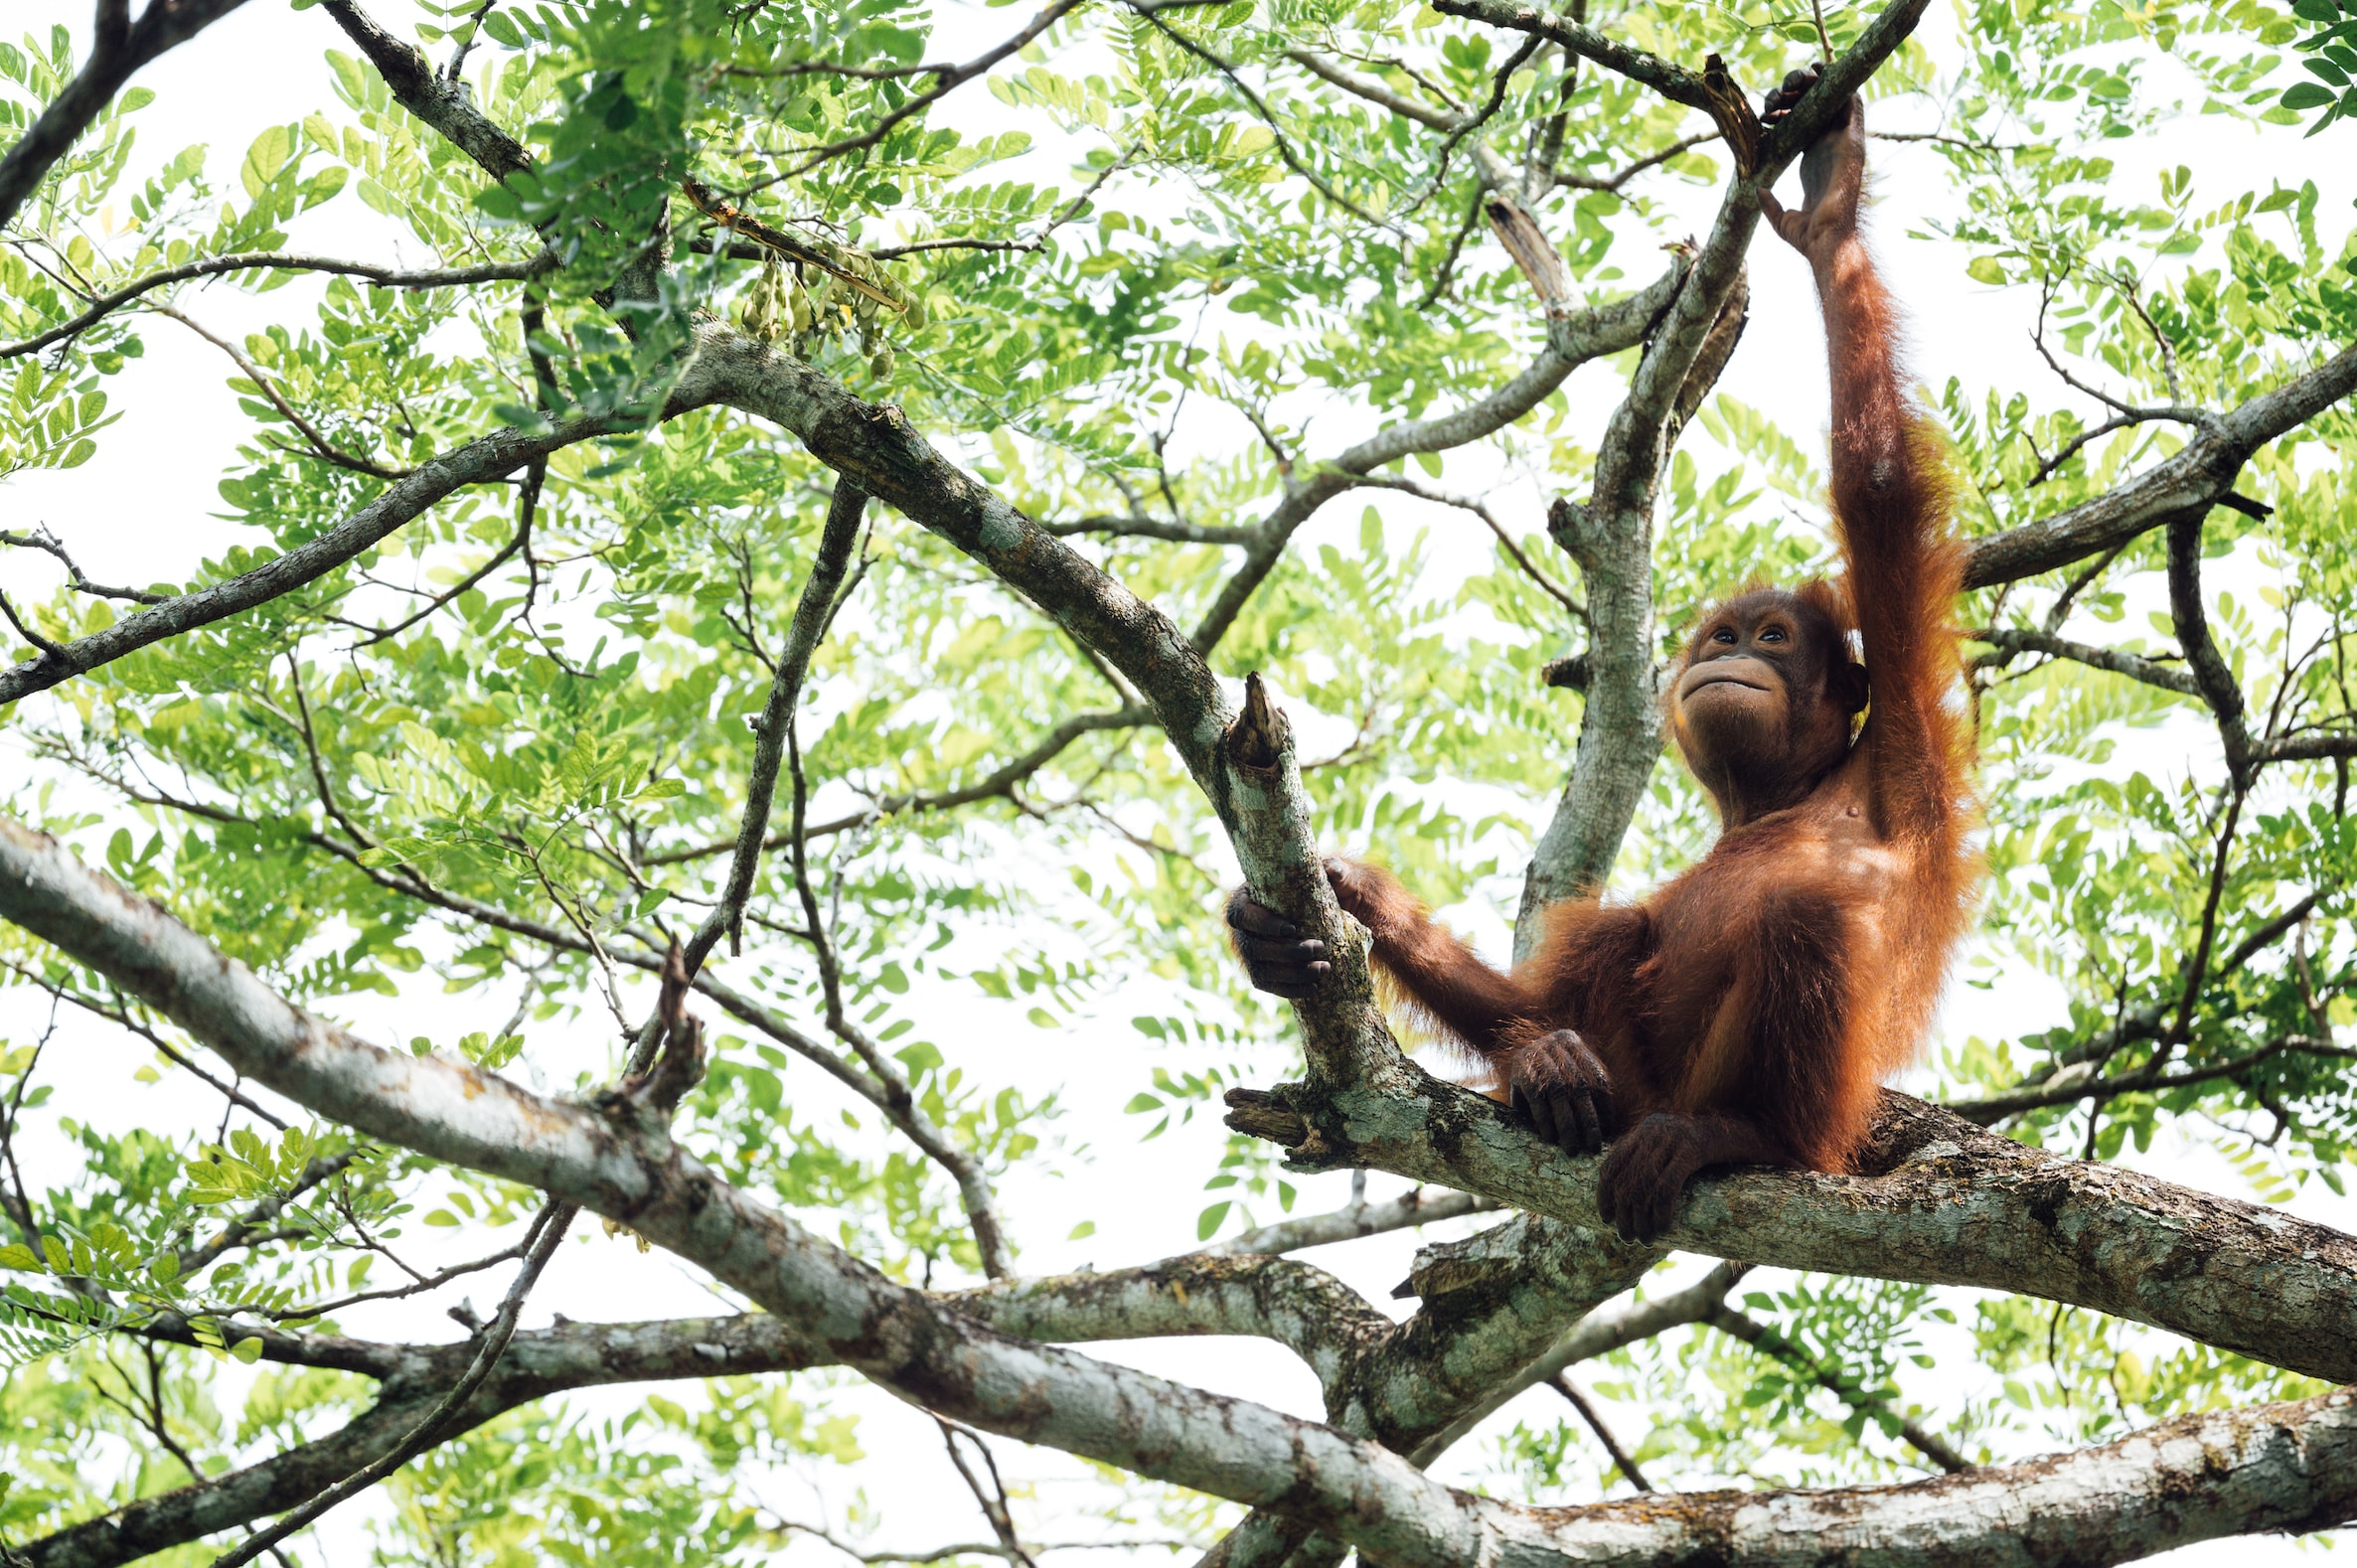

In [13]:

import requests
from PIL import Image

img_url = 'https://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80' 
image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
image

In [38]:
# unconditional image captioning
inputs = processor(image, return_tensors="pt").to(device)

out = model.generate(**inputs, max_new_tokens=20)
caption = processor.decode(out[0], skip_special_tokens=True)
prefix_response = "Final obserevation is that inside the image "
print(prefix_response +caption)

Final obserevation is that inside the image there is a monkey that is sitting in a tree


In [14]:
from langchain.tools import BaseTool

desc = (
    "use this tool when given the URL of an image that you'd like to be "
    "described. It will return a simple caption describing the image."
)

class ImageCaptionTool(BaseTool):
    name = "Image captioner"
    description = desc

    def _run(self, url: str):
        # download the image and convert to PIL object
        image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
        # preprocess the image
        inputs = processor(image, return_tensors="pt").to(device)
        # generate the caption
        out = model.generate(**inputs, max_new_tokens=20)
        # get the caption
        caption = processor.decode(out[0], skip_special_tokens=True)
        caption = "Inside the image" + caption
        return caption
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")
from langchain.agents import load_tools


In [15]:
from langchain.tools import BaseTool, StructuredTool, Tool, tool

image_cap = ImageCaptionTool()
calcu = CircumferenceTool()
tools = [
    Tool.from_function(
        func=image_cap.run,
        name="caption",
        description="use this tool when given the URL of an image that you'd like to be described. It will return a simple caption describing the image."
        
    ),
    Tool.from_function(
        func=calcu.run,
        name="calculator",
        description="use this tool when you need to calculate a circumference using the radius of a circle"
        
    )
]

In [16]:
from langchain.agents import initialize_agent
from langchain.chains.conversation.memory import ConversationBufferWindowMemory


agent = initialize_agent(
    agent="zero-shot-react-description",
    tools=tools,
    llm=llm,
    verbose=True,
    max_iterations=3,
    early_stopping_method='generate',
)


In [33]:
print(agent.agent.llm_chain.prompt)

input_variables=['input', 'agent_scratchpad'] output_parser=None partial_variables={} template="Answer the following questions as best you can. You have access to the following tools:\n\ncaption: use this tool when given the URL of an image that you'd like to be described. It will return a simple caption describing the image.\ncalculator: use this tool when you need to calculate a circumference using the radius of a circle\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [caption, calculator]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}" template_format='f-string' validate_template=True


In [45]:
agent("can you calculate the circumference of a circle that has a radius of 7.81mm")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.




> Entering new AgentExecutor chain...


Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


 yes, I can use the calculator tool to find the circumference
Action: calculator
Action Input: 7.81
Observation: 49.071677249072565
Thought: I now know the circumference is approximately 49.07mm
Final Answer: The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.

> Finished chain.


{'input': 'can you calculate the circumference of a circle that has a radius of 7.81mm',
 'output': 'The circumference of a circle with a radius of 7.81mm is approximately 49.07mm.'}

In [46]:
agent(f"What does the image in the following link show?\n{img_url}")

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.




> Entering new AgentExecutor chain...
 I don't know yet
Action: caption
Action Input: https://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80

Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.



Observation: Inside the imagethere is a monkey that is sitting in a tree
Thought: I now know the final answer
Final Answer: The image shows a monkey sitting in a tree.

> Finished chain.


{'input': 'What does the image in the following link show?\nhttps://images.unsplash.com/photo-1616128417859-3a984dd35f02?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2372&q=80',
 'output': 'The image shows a monkey sitting in a tree.'}